In [136]:
import cellxgene_census
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
census = cellxgene_census.open_soma()
census['census_info']['summary'].read().concat().to_pandas()

The "stable" release is currently 2023-12-15. Specify 'census_version="2023-12-15"' in future calls to open_soma() to ensure data consistency.


,soma_joinid,label,value
0,0,census_schema_version,1.2.0
1,1,census_build_date,2023-10-23
2,2,dataset_schema_version,3.1.0
3,3,total_cell_count,68683222
4,4,unique_cell_count,40356133
5,5,number_donors_homo_sapiens,15588
6,6,number_donors_mus_musculus,1990


In [3]:
mus = (
    census["census_data"]['mus_musculus']
    .obs.read(
        value_filter="is_primary_data==True",
        column_names=['dataset_id', 'nnz']
    )
    .concat()
    .to_pandas()
)

homo = (
    census["census_data"]['homo_sapiens']
    .obs.read(
        value_filter="is_primary_data==True",
        column_names=['dataset_id', 'nnz']
    )
    .concat()
    .to_pandas()
)

In [103]:
# mouse/human datasets
mus_ds_id = mus['dataset_id'].unique()
homo_ds_id = homo['dataset_id'].unique()

# dataset metadata
ds_meta = census['census_info']['datasets'].read().concat().to_pandas()
ds_meta = ds_meta[ds_meta['dataset_id'].isin(np.concatenate([mus_ds_id, homo_ds_id]))]

# filter for mouse/human
ds_meta_mus = ds_meta[ds_meta['dataset_id'].isin(mus_ds_id)]
ds_meta_homo = ds_meta[ds_meta['dataset_id'].isin(homo_ds_id)]

In [26]:
import requests
import numpy as np
import concurrent.futures


def get_publication_date(doi):
    url = f"https://api.crossref.org/works/{doi}"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        pub_date = data['message'].get('created', {}).get('date-time')
        return pub_date
    else:
        return np.nan

with concurrent.futures.ThreadPoolExecutor() as executor:
    pub_dates = list(executor.map(get_publication_date, ds_meta['collection_doi'].unique()))

pub_dates = dict(zip(ds_meta['collection_doi'].unique(), pub_dates))

In [104]:
mus_nnz = mus.groupby('dataset_id')['nnz'].sum()
homo_nnz = homo.groupby('dataset_id')['nnz'].sum()
all_nnz = pd.concat([mus_nnz, homo_nnz])

In [105]:
def process_dataset_meta(ds_meta, pub_dates, all_nnz):
    # Map publication dates
    ds_meta['pub_date'] = ds_meta['collection_doi'].map(pub_dates)
    ds_meta['pub_date'] = pd.to_datetime(ds_meta['pub_date'])

    # Remove missing publication dates
    ds_meta = ds_meta.dropna(subset=['pub_date'])

    # Merge with non-zero counts
    ds_meta = ds_meta.merge(all_nnz, left_on='dataset_id', right_index=True)

    # Group, sum, and reset index
    ds_meta = ds_meta.groupby(['collection_name', 'collection_id', 'collection_doi', 'pub_date'])[['dataset_total_cell_count', 'nnz']].sum().reset_index()
    ds_meta = ds_meta.rename(columns={'dataset_total_cell_count': 'collection_total_cell_count'})

    # Order by publication date
    ds_meta = ds_meta.sort_values(by='pub_date')

    # Calculate cumulative cell counts
    ds_meta['cum_cell_counts'] = ds_meta['collection_total_cell_count'].cumsum()

    # Calculate cumulative non-zero counts
    ds_meta['cum_nnz'] = ds_meta['nnz'].cumsum()

    return ds_meta


In [106]:
ds_meta = process_dataset_meta(ds_meta, pub_dates, all_nnz)
ds_meta_mus = process_dataset_meta(ds_meta_mus, pub_dates, all_nnz)
ds_meta_homo = process_dataset_meta(ds_meta_homo, pub_dates, all_nnz)

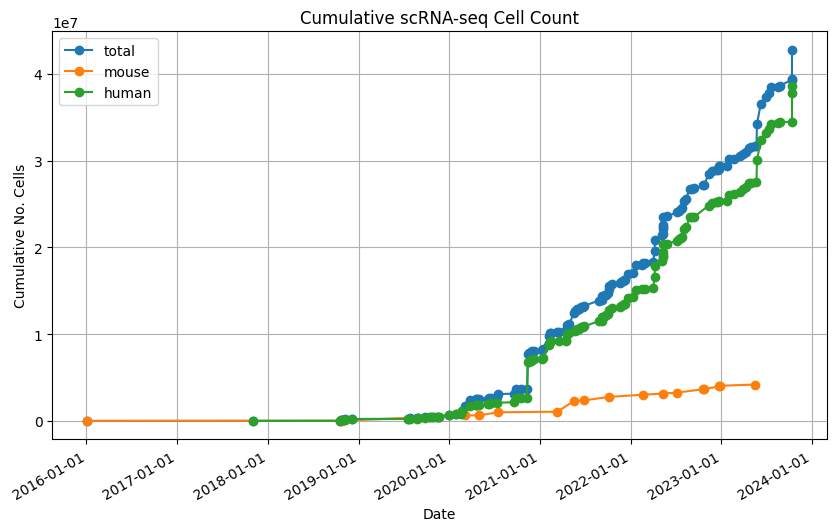

In [107]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

dataset_stats = {'total': ds_meta, 'mouse': ds_meta_mus, 'human': ds_meta_homo}

# Plotting
plt.figure(figsize=(10, 6))

for title,df in dataset_stats.items():
    plt.plot(df['pub_date'], df['cum_cell_counts'], marker='o', label=title)

# Formatting the date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative No. Cells')
plt.title('Cumulative scRNA-seq Cell Count')
plt.grid(True)
plt.gcf().autofmt_xdate()  # Auto-format for better date label appearance
plt.show()

In [112]:
# notable collections
ds_meta.sort_values(by='collection_total_cell_count', ascending=False).head(10)

,collection_name,collection_id,collection_doi,pub_date,collection_total_cell_count,nnz,cum_cell_counts,cum_nnz
5,A human cell atlas of fetal gene expression,c114c20f-1ef4-49a5-9c2e-d965787fb90c,10.1126/science.aba7721,2020-11-12 19:05:24+00:00,4062980,2383244615,7758472,7849385303
45,Human Brain Cell Atlas v1.0,283d65eb-dd53-496d-adb7-7570c7caa443,10.1126/science.add7046,2023-10-12 14:00:31+00:00,3369219,16104464935,42754317,85853774571
74,SEA-AD: Seattle Alzheimer’s Disease Brain Cell...,1ca90a2d-2943-483d-b678-b809bf464c30,10.1101/2023.05.08.539485,2023-05-24 18:09:49+00:00,2536269,13839464984,34244493,63362669001
121,The integrated Human Lung Cell Atlas,6f6d381a-7701-4781-935c-db10d30de293,10.1038/s41591-023-02327-2,2023-06-08 16:01:46+00:00,2282447,2084928108,36526940,65447597109
25,COVID-19 immune features revealed by a large-s...,0a839c4b-10d0-4d64-9272-684c49a2c8ba,10.1016/j.cell.2021.01.053,2021-02-05 01:08:14+00:00,1462702,2314736154,9737574,11088985949
44,High-resolution single-cell atlas reveals dive...,edb893ee-4066-4128-9aec-5eb2b03f8287,10.1016/j.ccell.2022.10.008,2022-11-10 15:31:02+00:00,1283972,1513296936,28484779,44108090893
90,Single-cell RNA-seq reveals the cell-type-spec...,436154da-bcf1-4130-9c8b-120ff9a888f2,10.1126/science.abf1970,2022-04-07 17:55:41+00:00,1263676,1001755426,20881479,31021105023
95,Single-cell eQTL mapping identifies cell type ...,dde06e0f-ab3b-46be-96a2-a8082383c4a1,10.1126/science.abf3041,2022-04-07 17:55:41+00:00,1248980,1185803063,19617803,30019349597
15,A taxonomy of transcriptomic cell types across...,e3aa612b-0d7d-4d3f-bbea-b8972a74dd4b,10.1016/j.cell.2021.04.021,2021-05-17 14:29:49+00:00,1242560,5417013210,12456854,18616465300
43,"Harmonized single-cell landscape, intercellula...",999f2a15-3d7e-440b-96ae-2c806799c08c,10.1101/2022.08.27.505439,2022-08-28 04:55:11+00:00,1135677,2274982695,26728580,41681258723


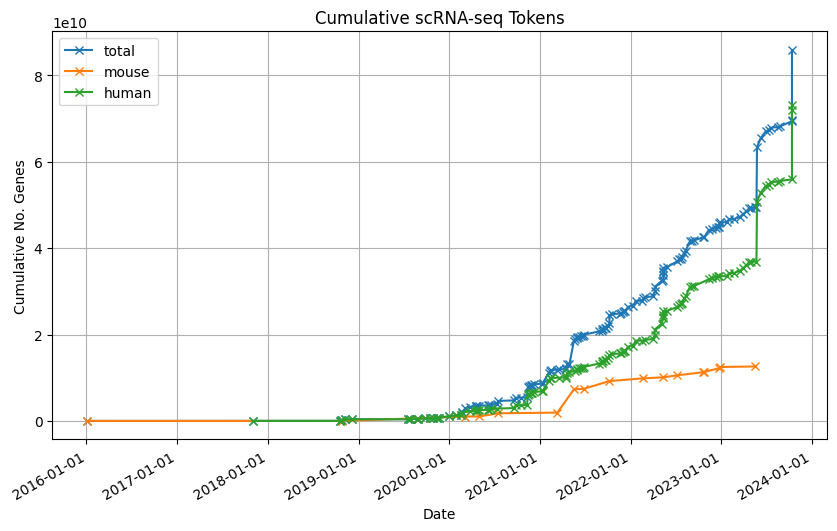

In [113]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plotting
plt.figure(figsize=(10, 6))

for title,df in dataset_stats.items():
    plt.plot(df['pub_date'], df['cum_nnz'], marker='x', label=title)

# Formatting the date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative No. Genes')
plt.title('Cumulative scRNA-seq Tokens')
plt.grid(True)
plt.gcf().autofmt_xdate()  # Auto-format for better date label appearance
plt.show()

In [117]:
print(f"Total number of tokens: {ds_meta['cum_nnz'].max():.3E}")

Total number of tokens: 8.585E+10


/Users/willconnell/miniconda3/envs/scaling-bio/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/willconnell/miniconda3/envs/scaling-bio/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


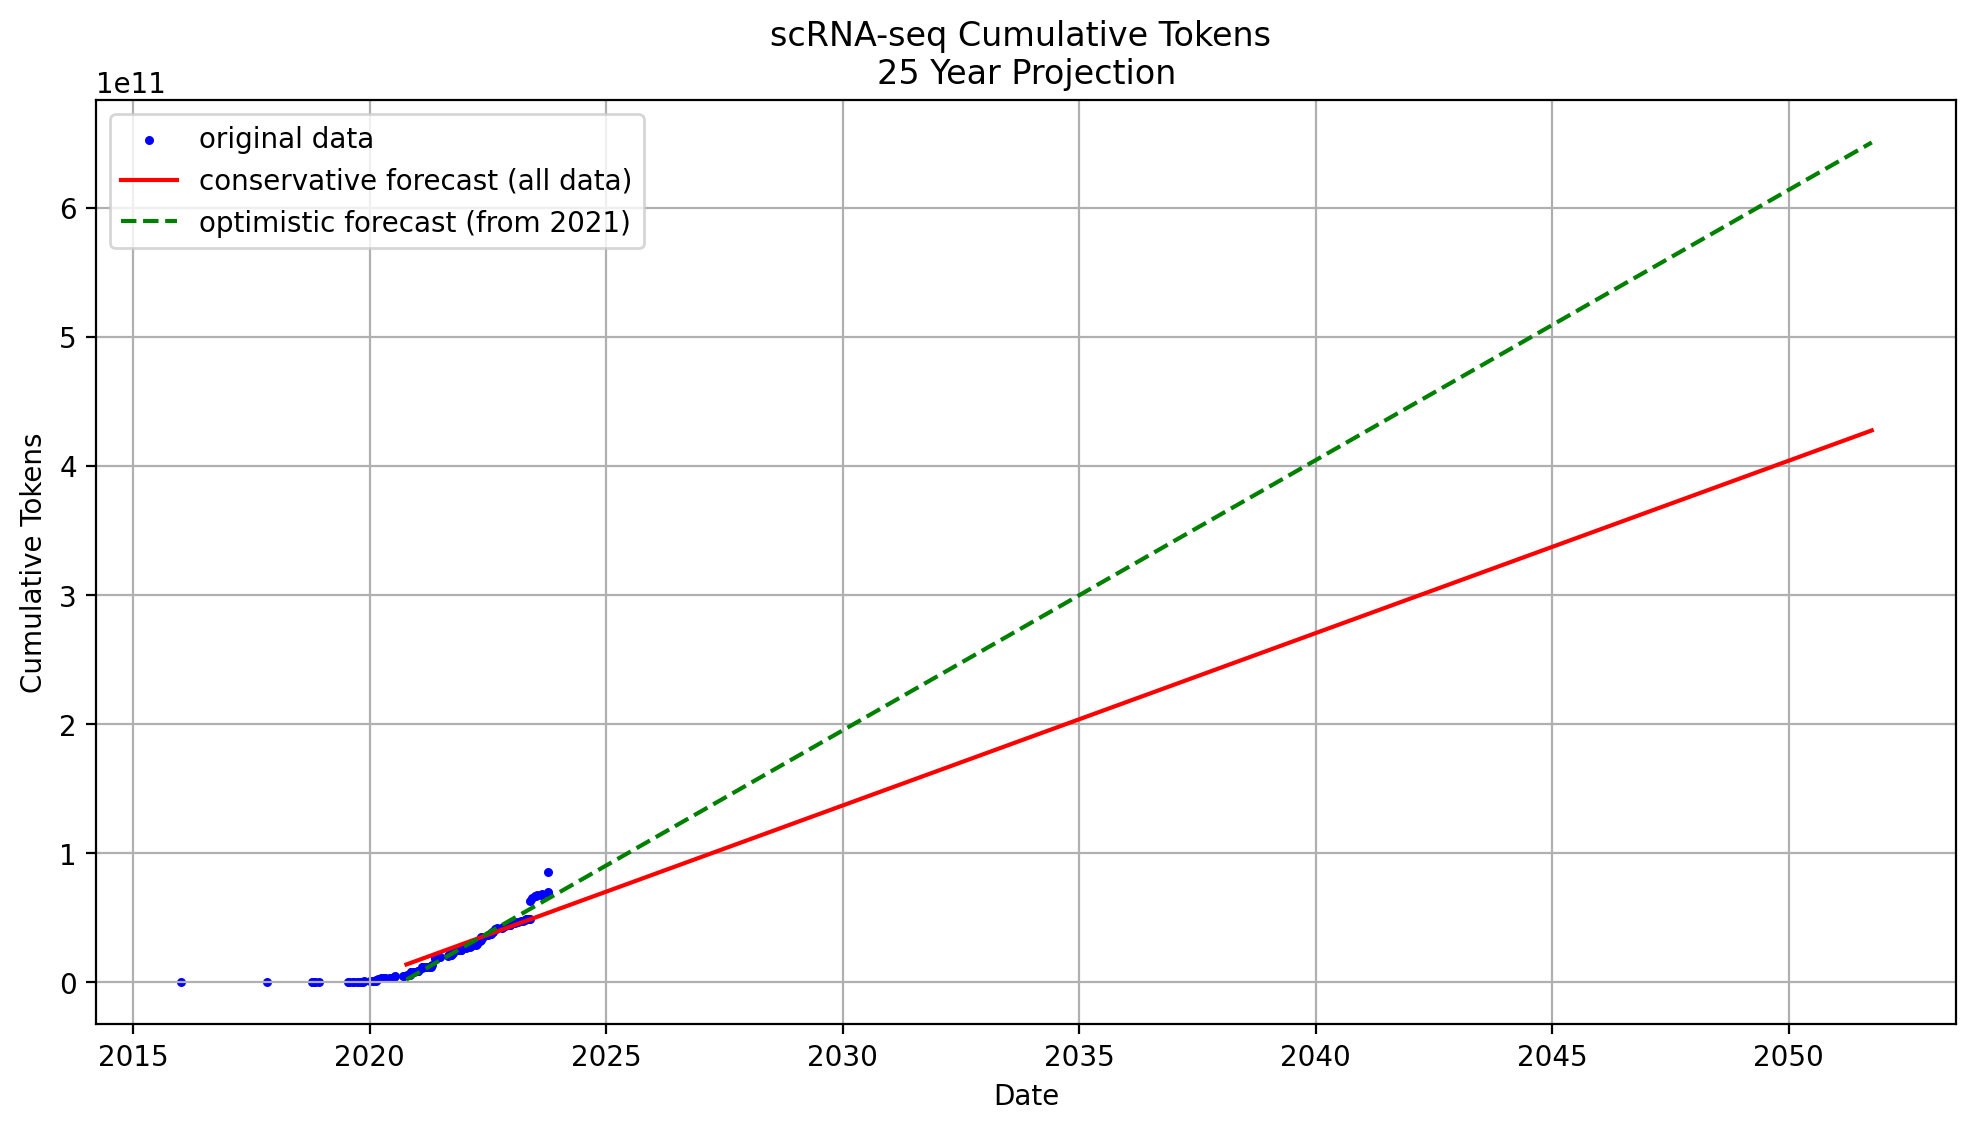

In [144]:
import matplotlib.dates as mdates
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from datetime import timedelta

def fit_and_plot_linear_models(ds_meta):
    # Ensure 'pub_date' is timezone-naive
    ds_meta['pub_date'] = ds_meta['pub_date'].dt.tz_localize(None)

    # Convert 'pub_date' to numeric (days since the earliest date)
    min_date = ds_meta['pub_date'].min()
    ds_meta['pub_date_numeric'] = (ds_meta['pub_date'] - min_date).dt.days

    # Prepare data for the first model
    X = ds_meta[['pub_date_numeric']]
    y = ds_meta['cum_nnz']

    # Fit the first linear model
    model_all = LinearRegression()
    model_all.fit(X, y)

    # Predict ~25 years
    max_date_numeric = ds_meta['pub_date_numeric'].max() - (3 * 365) # start ~2021
    future_dates_all = pd.Series(range(max_date_numeric, max_date_numeric + 31 * 365))
    future_predictions_all = model_all.predict(future_dates_all.to_frame())

    # Fit a second model using data from 2021 onwards
    start_2021 = (pd.Timestamp('2021-01-01') - min_date).days
    X_2021 = ds_meta[ds_meta['pub_date_numeric'] >= start_2021][['pub_date_numeric']]
    y_2021 = ds_meta[ds_meta['pub_date_numeric'] >= start_2021]['cum_nnz']

    model_2021 = LinearRegression()
    model_2021.fit(X_2021, y_2021)

    # Predict for the second model
    future_predictions_2021 = model_2021.predict(future_dates_all.to_frame())

    # Plot
    plt.figure(figsize=(12, 6))
    plt.scatter(ds_meta['pub_date'], y, color='blue', label='original data', s=5)
    plt.plot([min_date + timedelta(days=int(d)) for d in future_dates_all], future_predictions_all, color='red', label='conservative forecast (all data)')
    plt.plot([min_date + timedelta(days=int(d)) for d in future_dates_all], future_predictions_2021, color='green', label='optimistic forecast (from 2021)', linestyle='dashed')

    # Set x-axis to display every 5 years
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.xlabel('Date')
    plt.ylabel('Cumulative Tokens')
    plt.title('scRNA-seq Cumulative Tokens \n25 Year Projection')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
fit_and_plot_linear_models(ds_meta)
